In [11]:
import pandas as pd
import os
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import torch.nn.functional as F

In [23]:
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.infer.mcmc.api import MCMC
import pyro.poutine as poutine
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive, JitTrace_ELBO

from pyro.infer.mcmc.util import predictive
from pyro.distributions.util import sum_rightmost

In [13]:
from scipy.stats import uniform, norm
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [5]:
A = 1.2
b = -0.3
sigma = 0.2
N = 100

In [6]:
np.random.seed(0)
X = torch.from_numpy(uniform.rvs(size=N))
X.detach()
X = X.float()

In [7]:
e = torch.from_numpy(norm.rvs(loc=0, scale=sigma, size=N)).float()

In [8]:
y = A*X + b + e

In [9]:
y.detach()
y = y.float()

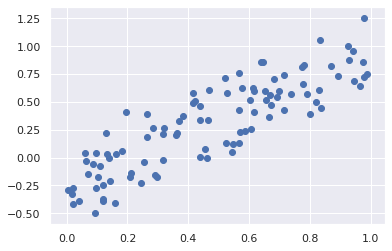

In [15]:
plt.scatter(X.numpy(), y.numpy())

In [18]:
class NNModel(nn.Module):
    def __init__(self):
        super(NNModel, self).__init__() 
        self.linear = nn.Linear(1, 1) 
        
    def forward(self, x):
        output = self.linear(x)
        return output

In [21]:
softplus = nn.Softplus()

In [20]:
def model(x, y):
    # Create unit normal priors over the parameters
    options = dict(dtype=x.dtype, device=x.device)
    loc = torch.zeros(1, 1, **options)
    scale = 2 * torch.ones(1, 1, **options)
    bias_loc = torch.zeros(1, **options)
    bias_scale = 2 * torch.ones(1, **options)
    A_prior = Normal(loc, scale).to_event(1)
    b_prior = Normal(bias_loc, bias_scale).to_event(1)
    priors = {'linear.weight': A_prior, 'linear.bias': b_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", NNModel, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()

    with pyro.plate("map", len(y)):
        # run the regressor forward conditioned on inputs
        prediction_mean = lifted_reg_model(x).squeeze(-1)
        pyro.sample("obs", Normal(prediction_mean, 1),
                    obs=y)

In [22]:
def guide(x, y):
    a_loc = torch.randn(1, 1, dtype=x.dtype, device=x.device)
    a_log_sig = -3 + 0.05 * torch.randn(1, 1, dtype=x.dtype, device=x.device)
    b_loc = torch.randn(1, dtype=x.dtype, device=x.device)
    b_log_sig = -3 + 0.05 * torch.randn(1, dtype=x.dtype, device=x.device)
    # register learnable params in the param store
    mw_param = pyro.param("guide_mean_weight", a_loc)
    sw_param = softplus(pyro.param("guide_log_scale_weight", a_log_sig))
    mb_param = pyro.param("guide_mean_bias", b_loc)
    sb_param = softplus(pyro.param("guide_log_scale_bias", b_log_sig))
    # gaussian guide distributions for w and b
    a_dist = Normal(mw_param, sw_param).to_event(1)
    b_dist = Normal(mb_param, sb_param).to_event(1)
    dists = {'linear.weight': a_dist, 'linear.bias': b_dist}
    # overloading the parameters in the module with random samples from the guide distributions
    lifted_module = pyro.random_module("module", NNModel, dists)
    # sample a regressor
    return lifted_module()

In [ ]:
optim = Adam({"lr": 0.05})
elbo = JitTrace_ELBO() if args.jit else Trace_ELBO()
svi = SVI(model, guide, optim, loss=elbo)
for j in range(10):
    # get indices of each batch
    all_batches = get_batch_indices(N, args.batch_size)
    for ix, batch_start in enumerate(all_batches[:-1]):
        batch_end = all_batches[ix + 1]
        batch_data = data[batch_start: batch_end]
        epoch_loss += svi.step(batch_data)
    if j % 100 == 0:
        print("epoch avg loss {}".format(epoch_loss/float(N)))

